# Classificação Binária

## Classificando Críticas de Filmes

A classificação de duas classes, também conhecida como **classificação binária** é possivelmente o problema de Machine Learning mais aplicado e comum.

Neste exemplo vamos classificar críticas de filmes como positiva ou negativa baseado no conteúdo de texto das críticas.

Iniciaremos importando as bibliotecas necessárias para o projeto

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Trabalharemos com o conjunto de dados [IMDB](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews): Um conjunto de 50.000 críticas altamente polarizadas da Internet Movie Database. Eles estão divididos em 25.000 críticas para treinamento e 25.000 para teste, cada um consistindo de 50% críticas negativas e 50% positivas.

Assim como o conjunto de dados MNIST, o conjunto de dados IMDB vem embutido na biblioteca Keras e já está pré-processado: as críticas (sequências de palavras) foram transformadas em sequências de números inteiros, onde cada inteiro se refere a uma específica palavra em um dicionário.

O código a seguir irá carregar o conjunto de dados

In [23]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000);

O argumento **num_words=10000** indica que iremos manter apenas as 10.000 palavras mais frequentes que ocorrem nos dados de treinamento. Palavras raras serão descartadas, o que nos permitirá trabalhar com dados vetoriais de tamanho gerenciável.

As variáveis **train_data** e **test_data** são listas de críticas, cada crítica é uma lista de índices de palavras (codificando assim uma sequência de palavras).

**train_labels** e **test_labels** são listas de 0's e 1's, em que 0 significa **negativo** e 1 **positivo**

Vamos então imprimir os dados para adquirir uma intuição a respeito da estrutura deles

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
print(train_labels[0])

1


Pelo fato de estarmos-nos restringindo às 10.000 mais frequentes palavras, nenhum índice de palavra irá exceder 10.000

In [6]:
max([max(sequence) for sequence in train_data])

9999

Caso queíramos decodificar uma dessas críticas para o inglês, podemos usar o seguinte script

In [24]:
word_index = imdb.get_word_index();
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i - 3, '-') for i in train_data[0]])
print(decoded_review)

- this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert - is an amazing actor and now the same being director - father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for - and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also - to the two little boy's that played the - of norman and paul they were just brilliant children are often left out of the - list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you thi

## Preparando os dados

Não podemos alimentar uma lista de inteiros em uma rede neural! 

Devemos transformar essas listas em tensors, para isso, vamos utilizar [One-Hot Enconding](https://en.wikipedia.org/wiki/One-hot), que irá codificar as nossas listas e transformá-las em vetores de 0's e 1's. Isso significaria, por exemplo, transformar a sequência [1,3] em um vetor 10.000-dimensional que será preenchido basicamente por 0's, exceto os índices 1 e 3, que serão 1. 

Então poderemos usar como primeira layer de nossa rede neural uma **Dense** layer capaz de lidar com dados vetoriais *floating-point*.

A função a seguir será responsável por vetorizar os dados

In [8]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0
    return results

Uma vez criada a função, vamos vetorizar os dados de treinamento e teste

In [9]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

Nossos dados ficarão então da seguinte forma

In [10]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

Devemos também vetorizar os labels, que nesse caso é muito simples, utilizaremos o método **asarray()** da biblioteca Numpy e transformaremos os dados em **float32** e então os dados estarão prontos para serem consumidos pela rede neural

In [11]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## Construindo a Rede Neural

Os dados de *input* são vetores e os *labels* são escalares (1's e 0's).

Um tipo de rede neural que tem uma boa perfomance em tal problema é uma simples pilha de *fully connected* (Dense) layers com funções de ativação [ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/).

O argumento passado para cada Dense layer (**16**) é o número de *hidden units* da layer. Uma *hidden unit* é uma dimensão no espaço de representação da layer.

Possuindo 16 hidden units significa que a matriz de weights (**W**) terá uma forma (dimensão_inputs,16): o produto escalar com **W** irá projetar os dados de *input* em um espaço de representação de 16-dimensões (e então será adicionado o vetor de bias **b** e aplicada a operação ReLU).

Podemos interpretar a dimensionalidade de nosso espaço de representação como "O quanto de liberdade que você está permitindo que a rede neural tenha ao aprender representações internas." Possuir mais *hidden units* (assim, um espaço de representação de mais dimensões) permite a rede neural aprender representações mais complexas, porém torna ela mais custosa em termos computacionais e pode levá-la a aprender padrões indesejados (padrões que irão aperfeiçoar a perfomance nos dados de treinamento, porém não nos dados de teste).

Existem duas principais decisões de arquitetura a serem feitas sobre essa pilha de Dense layers:

- Quantas layers utilizar
- Quantas *hidden units* usar para cada layer

Nas layers intermediárias iremos usar ReLU como a função de ativação, e a última layer usaremos a função sigmoid como ativação, para assim termos uma probabilidade como output (uma pontuação entre 0 e 1, indicando qual a probabilidade da amostra ter o target "1", em outras palavras, qual a probabilidade da crítica ser positiva).

Vamos então implementar a arquitetura de nosso modelo (rede neural):

In [12]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Finalmente, precisamos escolher uma função Loss e um *optimizer*. 

Uma vez que estamos lidando com um problema de classificação binária e o output da rede neural é uma probabilidade (lembre que terminamos com uma layer de unidade única com ativação sigmoid), é melhor usar a função loss 
*binary_crossentropy*. Crossentropy é uma quantidade do campo da Teoria da Informação que mede a distância entre as distribuições de probabilidade ou, neste caso, entre a distribuição da verdade fundamental e as previsões.

Vamos então configurar o modelo com o optimizer **rmsprop** e a função loss binary_crossentropy. Observe que também estamos monitorando a *accuracy*
durante o treinamento.

In [13]:
model.compile(optimizer=RMSprop(lr=0.001),loss='binary_crossentropy',metrics=['acc'])

## Validando a Abordagem

Com o objetivo de monitorar durante o treinamento a *accuracy* do modelo em relação aos dados que ele nunca viu antes, vamos criar um conjunto de validação separando 10.000 amostras dos dados de treinamento originais.

In [14]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

In [15]:
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

Treinaremos então o modelo por 20 *epochs* (20 iterações em todas as amostras nos tensors **x_train** e **y_train**), em *mini-batches* de 512 amostras. Ao mesmo tempo, monitoraremos a Loss e a Accuracy nas 10.000 amostras que separamos. Fazemos isso passando os dados de validação como o argumento de **validation_data**.

In [16]:
history = model.fit(partial_x_train,partial_y_train,epochs=20,batch_size=512,validation_data=(x_val, y_val))

Epoch 1/20
30/30 [==============================] - 1s 28ms/step - loss: 0.5261 - acc: 0.7743 - val_loss: 0.4007 - val_acc: 0.8643
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3129 - acc: 0.9007 - val_loss: 0.3072 - val_acc: 0.8862
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2290 - acc: 0.9267 - val_loss: 0.2796 - val_acc: 0.8910
Epoch 4/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1798 - acc: 0.9431 - val_loss: 0.2746 - val_acc: 0.8892
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1453 - acc: 0.9543 - val_loss: 0.2927 - val_acc: 0.8836
Epoch 6/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1214 - acc: 0.9616 - val_loss: 0.2942 - val_acc: 0.8835
Epoch 7/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1019 - acc: 0.9691 - val_loss: 0.3350 - val_acc: 0.8765
Epoch 8/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0836 - a

Observe que a chamada para **model.fit()** retorna um objeto **History**. Este objeto possui um membro history, que é um dicionário contendo dados sobre tudo o que aconteceu durante o treinamento, vamos utilizar esses dados para construir um DataFrame com o auxílio da biblioteca Pandas.

In [17]:
metrics = pd.DataFrame(model.history.history)
metrics

,loss,acc,val_loss,val_acc
0,0.526059,0.774333,0.400726,0.8643
1,0.312950,0.900733,0.307218,0.8862
2,0.228973,0.926667,0.279631,0.8910
3,0.179773,0.943067,0.274615,0.8892
4,0.145326,0.954267,0.292734,0.8836
5,0.121445,0.961600,0.294161,0.8835
6,0.101892,0.969133,0.335004,0.8765
7,0.083600,0.976867,0.341340,0.8789
8,0.071611,0.980533,0.353487,0.8785
9,0.058315,0.985400,0.377455,0.8787


O dicionário contém quatro entradas: uma por métrica que estava sendo monitorada durante treinamento e durante a validação. 

Vamos agora usar Matplotlib para construir um gráfico da Loss de treinamento e validação, assim como a Accuracy de treinamento e validação.

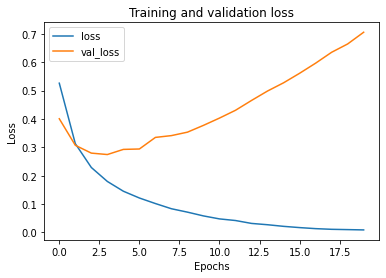

In [18]:
metrics[['loss','val_loss']].plot()
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

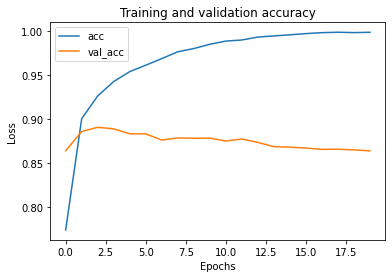

In [19]:
metrics[['acc','val_acc']].plot()
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Como podemos observar, a Loss de treinamento diminui a cada **epoch**, e a Accuracy do treinamento aumenta a cada **epoch**. Isso é o que se espera ao executar a otimização *gradient descent* - a quantidade que estamos tentando minimizar deve ser menor com cada iteração. Porém esse não é o caso da Loss de validação e Accuracy: eles parecem atingir um pico na quarta epoch. Este é um exemplo de **overfitting**: um modelo com melhor desempenho nos dados de treinamento não é necessariamente um modelo que funcionará melhor em dados que nunca viu antes, após a segunda epoch, estamos superotimizando os dados de treinamento e terminamos com representações de aprendizagem que são específicas para os dados de treinamento e não generalizam para dados fora do conjunto de treinamento.

Nesse caso, para evitar o overfitting, podemos interromper o treinamento após quatro epochs.

Vamos então treinar uma nova rede do zero por quatro epochs e, em seguida, avaliá-la nos dados de teste.

In [20]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(10000,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 11ms/step - loss: 0.4533 - accuracy: 0.8250
Epoch 2/4
49/49 [==============================] - 1s 12ms/step - loss: 0.2595 - accuracy: 0.9099
Epoch 3/4
49/49 [==============================] - 1s 12ms/step - loss: 0.2004 - accuracy: 0.9292
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.3088 - accuracy: 0.8791


Os resultados finais que temos são os seguintes

In [21]:
print(results)

[0.3087579607963562, 0.8790799975395203]


Nos levando a alcançar uma accuracy de 88%

Uma vez que nossa rede neural está treinada, agora podemos utilizá-la para fazer previsões. 

Podemos gerar a probabilidade das críticas serem **positivos** usando o método de **predict()**

In [22]:
model.predict(x_test)

array([[0.25012797],
       [0.9999945 ],
       [0.98629797],
       ...,
       [0.17432064],
       [0.10161123],
       [0.71477944]], dtype=float32)